### Sensors

In [ ]:
import os.path as op
import numpy as np
import pandas as pd
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from base import ensure_dir
from config import *
import gc
import os
import sys

# params
subjects = SUBJS
subject = subjects[0]
lock = "stim"
trial_type = 'pattern'

data_path = DATA_DIR
subjects_dir = FREESURFER_DIR
folds = 10
solver = 'lbfgs'
scoring = "accuracy"

is_cluster = os.getenv("SLURM_ARRAY_TASK_ID") is not None
overwrite = False
verbose = True
jobs = -1

In [39]:
# set-up the classifier and cv structure
clf = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=100000, solver=solver, class_weight="balanced", random_state=42, n_jobs=jobs))
# clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=100000, solver=solver, class_weight="balanced", random_state=42, n_jobs=-1))
clf = SlidingEstimator(clf, scoring=scoring, n_jobs=jobs, verbose=verbose)
cv = StratifiedKFold(folds, shuffle=True, random_state=42)

In [14]:
epo_dir = data_path / lock
epo_fnames = [epo_dir / f'{f}' for f in sorted(os.listdir(epo_dir)) if '.fif' in f and subject in f and not f.startswith('.')]
all_epo = [mne.read_epochs(fname, preload=True, verbose="error") for fname in epo_fnames]
for epoch in all_epo: # see mne.preprocessing.maxwell_filter to realign the runs to a common head position. On raw data.
    epoch.info['dev_head_t'] = all_epo[0].info['dev_head_t']
epoch = mne.concatenate_epochs(all_epo)

beh_dir = data_path / 'behav'
beh_fnames = [beh_dir / f'{f}' for f in sorted(os.listdir(beh_dir)) if '.pkl' in f and subject in f and not f.startswith('.')]
all_beh = [pd.read_pickle(fname) for fname in beh_fnames]
behav = pd.concat(all_beh)
    
if trial_type == 'pattern':
    pattern = behav.trialtypes == 1
    X = epoch.get_data()[pattern]
    y = behav.positions[pattern]
elif trial_type == 'random':
    random = behav.trialtypes == 2
    X = epoch.get_data()[random]
    y = behav.positions[random]
else:
    X = epoch.get_data()
    y = behav.positions
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]

Not setting metadata
1383 matching events found
Applying baseline correction (mode: mean)


/var/folders/0x/4l778zdn0l524g42s5_nc48h0000gn/T/ipykernel_1896/2001162350.py:15: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epoch.get_data()[pattern]


In [9]:
sensor_scores = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose, n_jobs=jobs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]



  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]




  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]





  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]






  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]







  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]








 12%|█▏        | Fitting SlidingEstimator : 10/82 [00:05<00:35,    2.02it/s]A
 16%|█▌        | Fitting SlidingEstimator : 13/82 [00:05<00:25,    2.67it/s][A

  1%|          | Fitting SlidingEstimator : 1/82 [00:05<07:29,    5.55s/it]
  2%|

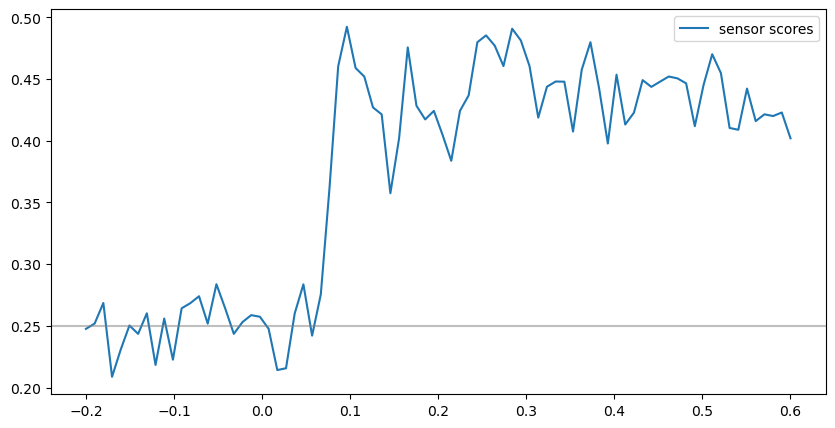

In [12]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(times, sensor_scores.mean(0), label='sensor scores')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [16]:
noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="empirical", rank="info", verbose=verbose)
# compute data covariance matrix on evoked data
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="empirical", rank="info", verbose=verbose)
# conpute rank
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
# read forward solution
fwd_fname = RESULTS_DIR / "fwd" / lock / f"{subject}-all-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)

Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 29043
[done]
Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 85746
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.7e-13 (2.2e-16 eps * 246 dim * 3.1  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Reading forward solution from /Users/coum/Desktop/asrt/results/fwd/stim/sub01-all-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 246 channels, free orientations)
    Source spac

In [27]:
from mne.beamformer import make_lcmv, apply_lcmv_epochs
from sklearn.decomposition import PCA
from mne.decoding import UnsupervisedSpatialFilter
pca = UnsupervisedSpatialFilter(PCA(1000), average=False)
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov=data_cov, noise_cov=noise_cov,
                pick_ori=None, rank=rank, reduce_rank=True, reg=0.05, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
data = np.array([stc.data for stc in stcs])
stcs_data = pca.fit_transform(data)

if trial_type == 'pattern':
    pattern = behav.trialtypes == 1
    X = stcs_data[pattern]
    y = behav.positions[pattern]
elif trial_type == 'random':
    random = behav.trialtypes == 2
    X = stcs_data[random]
    y = behav.positions[random]
else:
    X = stcs_data
    y = behav.positions    
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]

Computing rank from covariance with rank={'mag': 246}
Computing rank from covariance with rank={'mag': 246}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
combining the current components...
Processing epoch : 2
combining the current components...
Processing epoch : 3
combining the current components...
Processing epoch : 4
combining the current components...
Processing epoch : 5
combining the current components...
Processing epoch : 6
combining the current components...
Processing epoch : 7
combining the current components...
Processing epoch : 8
combining the curre

In [28]:
src_sc = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose, n_jobs=jobs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
 24%|██▍       | Fitting SlidingEstimator : 20/82 [00:00<00:02,   24.03it/s]
 49%|████▉     | Fitting SlidingEstimator : 40/82 [00:01<00:01,   26.50it/s]
  2%|▏         | Fitting SlidingEstimator : 2/82 [00:00<00:30,    2.59it/s]
  4%|▎         | Fitting SlidingEstimator : 3/82 [00:00<00:20,    3.77it/s]
 11%|█         | Fitting SlidingEstimator : 9/82 [00:00<00:06,   11.25it/s]
 16%|█▌        | Fitting SlidingEstimator : 13/82 [00:00<00:04,   15.85it/s]
 20%|█▉        | Fitting SlidingEstimator : 16/82 [00:00<00:03,   18.91it/s]
 21%|██        | Fitting SlidingEstimator : 17/82 [00:01<00:03,   18.45it/s]
 52%|█████▏    | Fitting SlidingEstimator : 43/82 [00:02<00:02,   19.35it/s]
 70%|██████▉   | Fitting SlidingEstimator : 57/82 [00:02<00:00,   26.46it/s]

 73%|███████▎  | Fitting SlidingEstimator : 60/82 [00:02<00:00,   24.41it/s]A
 26%|██▌       | Fitting SlidingEstimator : 21/82 [00:01<00:04,   13.98it/s]


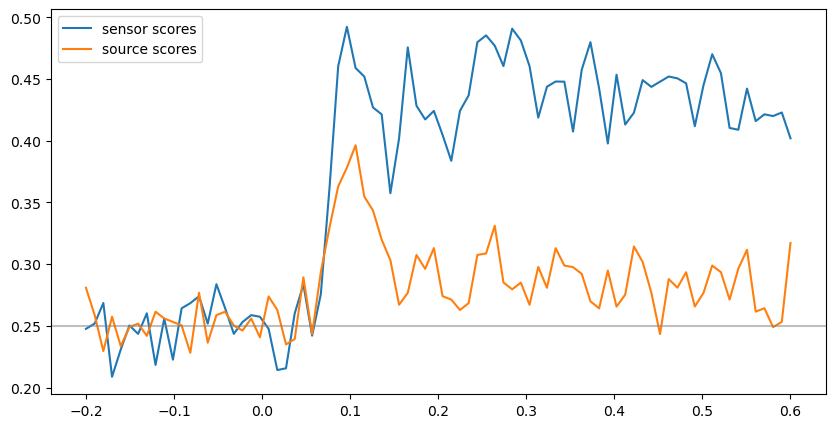

In [31]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(times, sensor_scores.mean(0), label='sensor scores')
ax.plot(times, src_sc.mean(0), label='source scores')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [41]:
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank='info')
stcs = apply_lcmv_epochs(epoch, filters, verbose=verbose)
data = np.array([stc.data for stc in stcs])
stcs_data_power = pca.fit_transform(data)

Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch :

In [42]:
stcs_data_power.shape
pattern = behav.trialtypes == 1
X = stcs_data_power[pattern]
y = behav.positions[pattern]

In [43]:
src_power_sc = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.8s finished


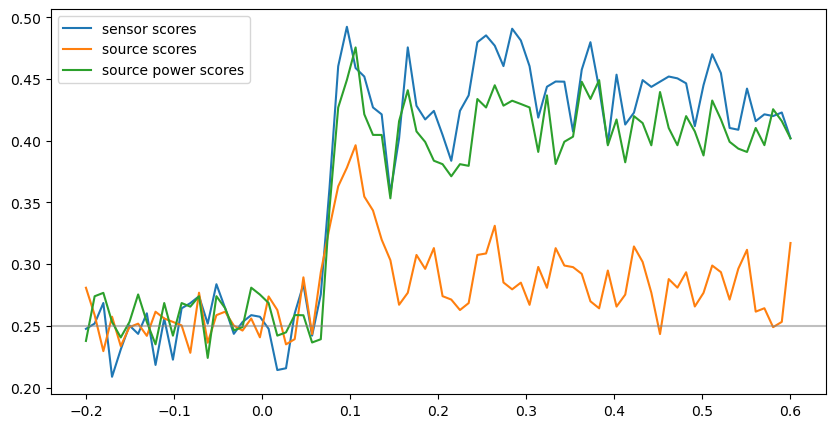

In [44]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(times, sensor_scores.mean(0), label='sensor scores')
ax.plot(times, src_sc.mean(0), label='source scores')
ax.plot(times, src_power_sc.mean(0), label='source power scores')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [45]:
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank=rank)
stcs = apply_lcmv_epochs(epoch, filters, verbose=verbose)
data = np.array([stc.data for stc in stcs])
stcs_data_power = pca.fit_transform(data)

Computing rank from covariance with rank={'mag': 246}
Computing rank from covariance with rank={'mag': 246}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch : 14
Processing epoch : 15
Processing epoch : 16
Processing epoch : 17
Processing epoch : 18
Processing epoch : 19
Processing epoch : 20
Processi

In [46]:
stcs_data_power.shape
pattern = behav.trialtypes == 1
X = stcs_data_power[pattern]
y = behav.positions[pattern]
power_sc_rank = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

/Users/coum/opt/anaconda3/envs/mne/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.2s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.5s finished


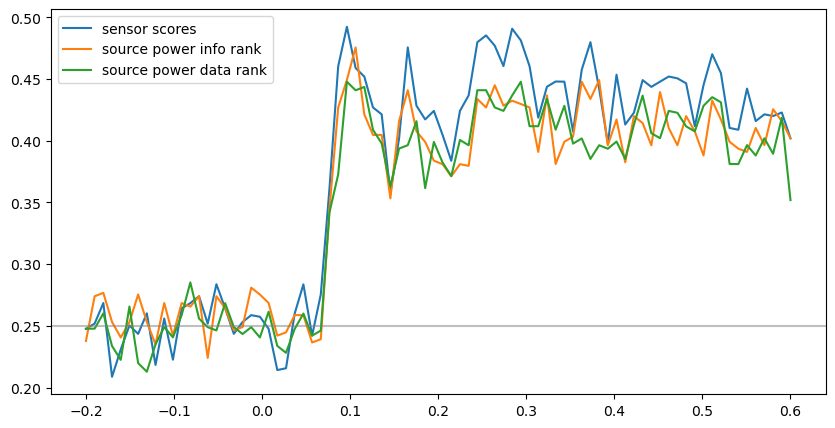

In [ ]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(times, sensor_scores.mean(0), label='sensor scores')
# ax.plot(times, src_sc.mean(0), label='source scores')
ax.plot(times, src_power_sc.mean(0), label='source power info rank')
ax.plot(times, power_sc_rank.mean(0), label='source power data rank')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [49]:
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank=rank)
stcs = apply_lcmv_epochs(epoch, filters, verbose=verbose)
data = np.array([stc.data for stc in stcs])
stcs_data_power = pca.fit_transform(data)
stcs_data_power.shape
pattern = behav.trialtypes == 1
X = stcs_data_power[pattern]
y = behav.positions[pattern]
power_sc_rank_noise = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)


Computing rank from covariance with rank=None
    Using tolerance 1.7e-13 (2.2e-16 eps * 246 dim * 3.1  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Computing rank from covariance with rank={'mag': 246}
Computing rank from covariance with rank={'mag': 246}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Proces

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.6s finished


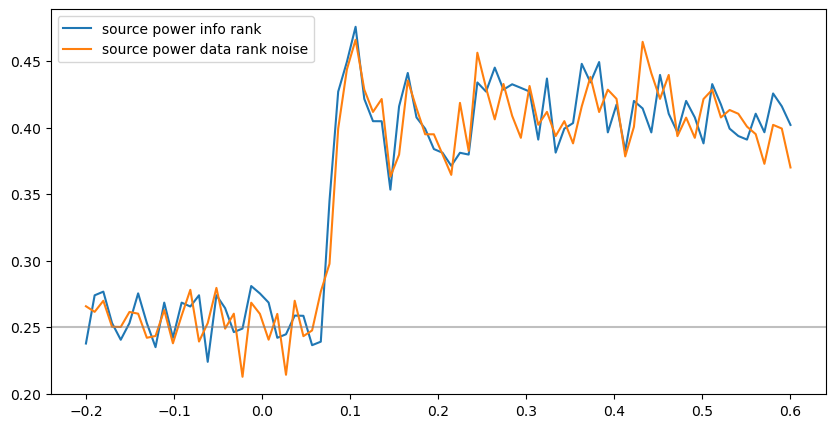

In [74]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(times, sensor_scores.mean(0), label='sensor scores')
# ax.plot(times, src_sc.mean(0), label='source none')
ax.plot(times, src_power_sc.mean(0), label='source power info rank')
# ax.plot(times, power_sc_rank.mean(0), label='source power data rank')
ax.plot(times, power_sc_rank_noise.mean(0), label='source power data rank noise')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [76]:
# rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm=None,
                    rank='info')
stcs = apply_lcmv_epochs(epoch, filters, verbose=verbose)
data = np.array([stc.data for stc in stcs])
stcs_data_power = pca.fit_transform(data)
stcs_data_power.shape
pattern = behav.trialtypes == 1
X = stcs_data_power[pattern]
y = behav.positions[pattern]
none_power = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)


Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch :

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.1s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.0s finished


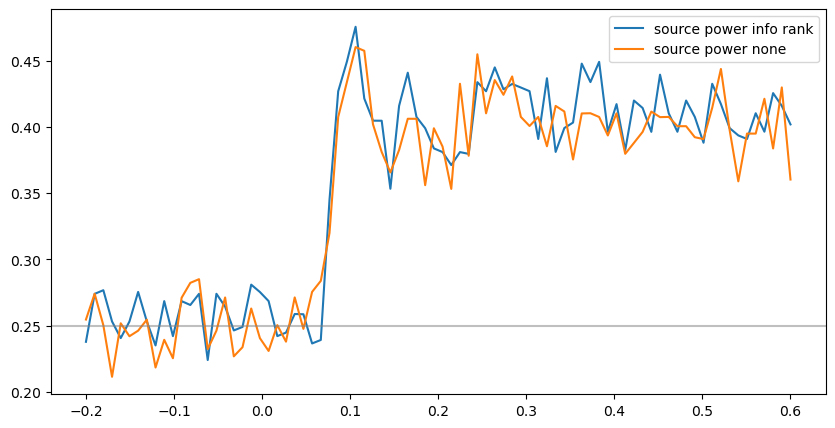

In [77]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(times, sensor_scores.mean(0), label='sensor scores')
# ax.plot(times, src_sc.mean(0), label='source none')
ax.plot(times, src_power_sc.mean(0), label='source power info rank')
# ax.plot(times, power_sc_rank.mean(0), label='source power data rank')
# ax.plot(times, power_sc_rank_noise.mean(0), label='source power data rank noise')
ax.plot(times, none_power.mean(0), label='source power none')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [78]:
data_cov = mne.compute_covariance(epoch, tmin=.05, tmax=.6, method="empirical", rank="info", verbose=verbose)
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank='info')
stcs = apply_lcmv_epochs(epoch, filters, verbose=verbose)
data = np.array([stc.data for stc in stcs])
stcs_data_power = pca.fit_transform(data)
stcs_data_power.shape
pattern = behav.trialtypes == 1
X = stcs_data_power[pattern]
y = behav.positions[pattern]
power_d = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)


Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 78831
[done]
Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.1s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.1s finished


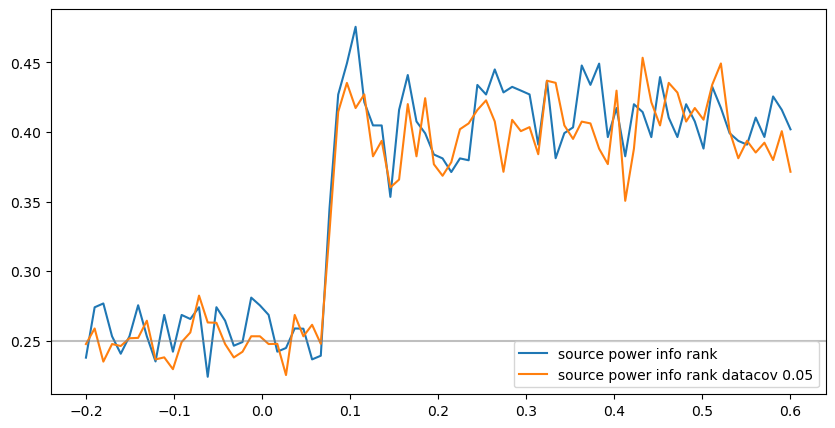

In [79]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(times, sensor_scores.mean(0), label='sensor scores')
# ax.plot(times, src_sc.mean(0), label='source none')
ax.plot(times, src_power_sc.mean(0), label='source power info rank')
# ax.plot(times, power_sc_rank.mean(0), label='source power data rank')
# ax.plot(times, power_sc_rank_noise.mean(0), label='source power data rank noise')
# ax.plot(times, none_power.mean(0), label='source power none')
ax.plot(times, power_d.mean(0), label='source power info rank datacov 0.05')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [80]:
n_parcels = 200
n_networks = 7
network = NETWORKS[0]
label_path = RESULTS_DIR / f'networks_{n_parcels}_{n_networks}' / subject
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov=data_cov, noise_cov=noise_cov,
                pick_ori=None, rank=rank, reduce_rank=True, reg=0.05, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
lh_label, rh_label = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')
stcs_data = np.array([stc.in_label(lh_label + rh_label).data for stc in stcs])
assert len(stcs_data) == len(behav)

Computing rank from covariance with rank={'mag': 246}
Computing rank from covariance with rank={'mag': 246}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
combining the current components...
Processing epoch : 2
combining the current components...
Processing epoch : 3
combining the current components...
Processing epoch : 4
combining the current components...
Processing epoch : 5
combining the current components...
Processing epoch : 6
combining the current components...
Processing epoch : 7
combining the current components...
Processing epoch : 8
combining the curre

In [82]:
pattern = behav.trialtypes == 1
X = stcs_data[pattern]
y = behav.positions[pattern]
visual_none = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

/Users/coum/opt/anaconda3/envs/mne/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.5min finished


In [83]:
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank='info')
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
lh_label, rh_label = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')
stcs_data = np.array([stc.in_label(lh_label + rh_label).data for stc in stcs])
assert len(stcs_data) == len(behav)
pattern = behav.trialtypes == 1
X = stcs_data[pattern]
y = behav.positions[pattern]
visual_power = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch :

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.2min finished


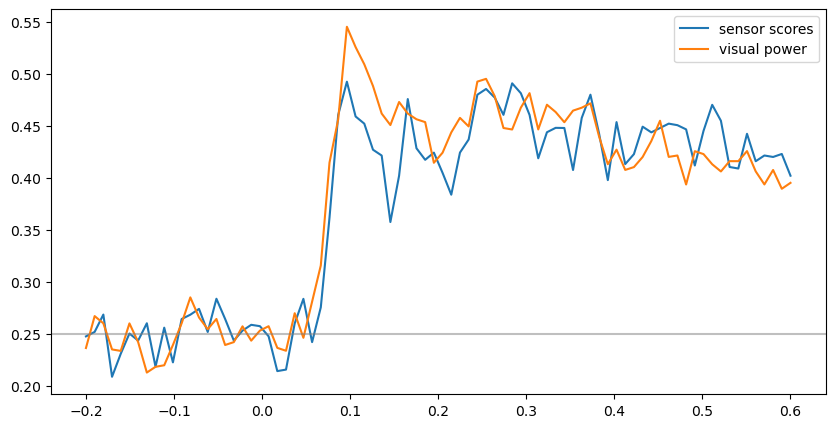

In [87]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(times, sensor_scores.mean(0), label='sensor scores')
# ax.plot(times, visual_none.mean(0), label='visual none')
ax.plot(times, visual_power.mean(0), label='visual power')
# ax.plot(times, src_sc.mean(0), label='source scores')

ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [88]:
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank='info')
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
lh_label, rh_label = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')
stcs_data = np.array([stc.in_label(lh_label + rh_label).data for stc in stcs])
assert len(stcs_data) == len(behav)
pattern = behav.trialtypes == 1
X = stcs_data[pattern]
y = behav.positions[pattern]
visual_power_no_reg = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch :

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   59.3s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished


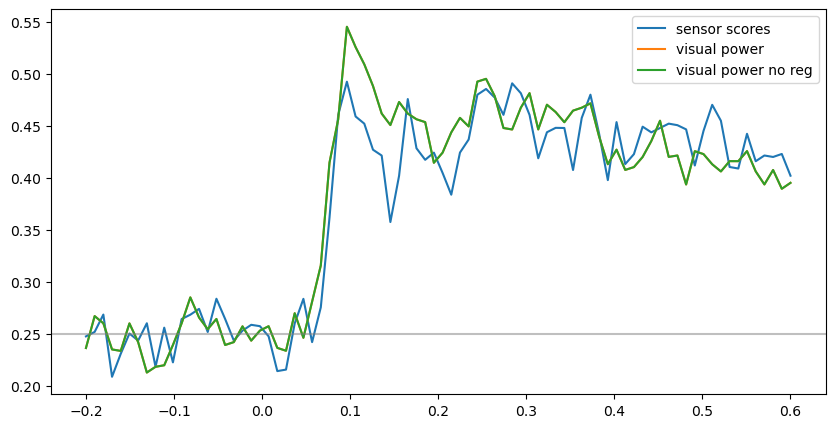

In [91]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(times, sensor_scores.mean(0), label='sensor scores')
ax.plot(times, visual_power.mean(0), label='visual power')
ax.plot(times, visual_power_no_reg.mean(0), label='visual power no reg')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [92]:
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov=data_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank='info')
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
lh_label, rh_label = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')
stcs_data = np.array([stc.in_label(lh_label + rh_label).data for stc in stcs])
assert len(stcs_data) == len(behav)
pattern = behav.trialtypes == 1
X = stcs_data[pattern]
y = behav.positions[pattern]
visual_power_no_noise = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch :

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.1s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished


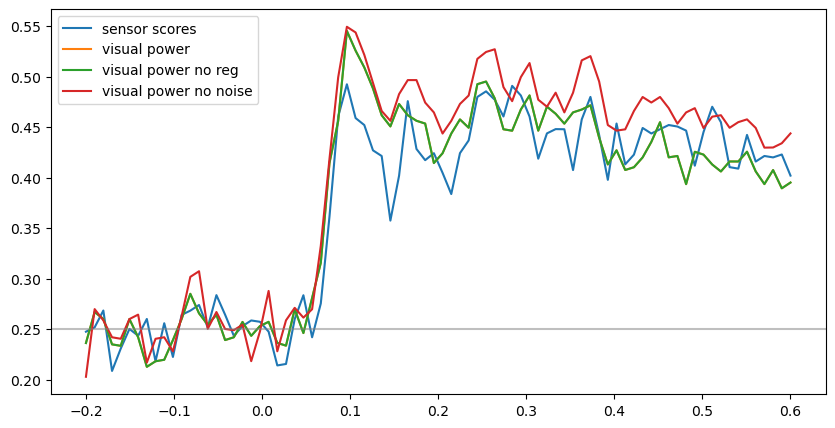

In [93]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(times, sensor_scores.mean(0), label='sensor scores')
ax.plot(times, visual_power.mean(0), label='visual power')
ax.plot(times, visual_power_no_reg.mean(0), label='visual power no reg')
ax.plot(times, visual_power_no_noise.mean(0), label='visual power no noise')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [95]:
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov=data_cov, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank='info', reduce_rank=True)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
lh_label, rh_label = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')
stcs_data = np.array([stc.in_label(lh_label + rh_label).data for stc in stcs])
assert len(stcs_data) == len(behav)
pattern = behav.trialtypes == 1
X = stcs_data[pattern]
y = behav.positions[pattern]
visual_power_reduce_rank = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Computing rank from covariance with rank='info'
    MAG: rank 246 after 0 projectors applied to {n_chan} channel{_pl(n_chan)}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch :

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.1s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.5min finished


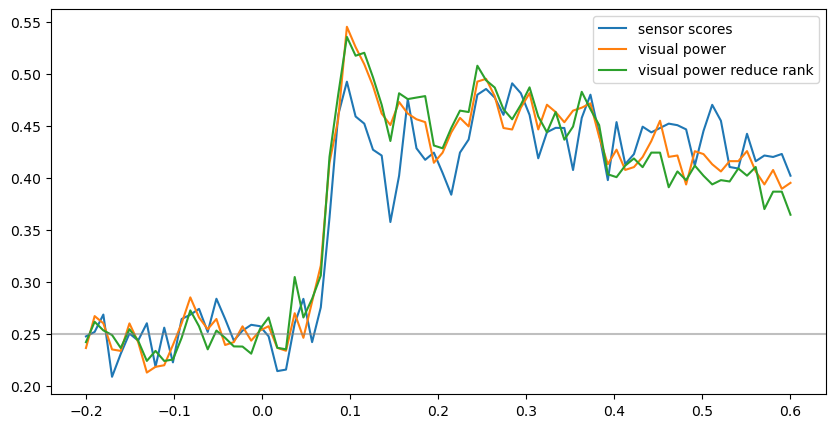

In [97]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(times, sensor_scores.mean(0), label='sensor scores')
ax.plot(times, visual_power.mean(0), label='visual power')
# ax.plot(times, visual_power_no_reg.mean(0), label='visual power no reg')
# ax.plot(times, visual_power_no_noise.mean(0), label='visual power no noise')
ax.plot(times, visual_power_reduce_rank.mean(0), label='visual power reduce rank')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()

In [98]:
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori="max-power", weight_norm="unit-noise-gain",
                    rank=rank, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
lh_label, rh_label = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')
stcs_data = np.array([stc.in_label(lh_label + rh_label).data for stc in stcs])
assert len(stcs_data) == len(behav)
pattern = behav.trialtypes == 1
X = stcs_data[pattern]
y = behav.positions[pattern]
final_scores = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)


Computing rank from covariance with rank=None
    Using tolerance 1.8e-13 (2.2e-16 eps * 246 dim * 3.3  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Computing rank from covariance with rank={'mag': 246}
Computing rank from covariance with rank={'mag': 246}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Proces

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished


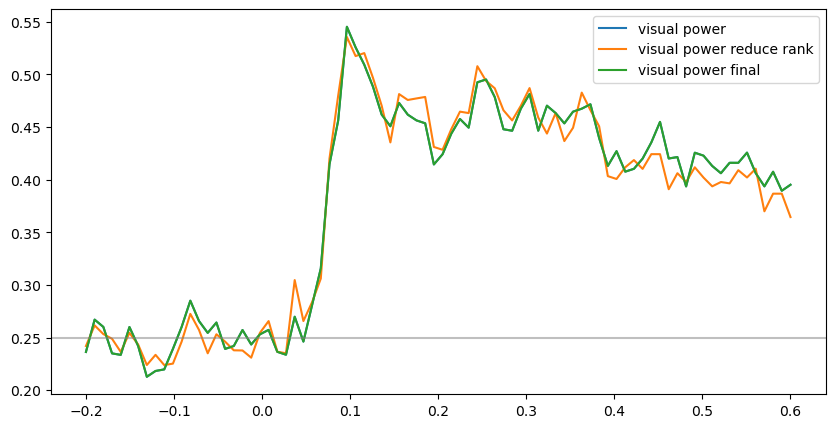

In [100]:
import matplotlib.pyplot as plt
times = np.linspace(-0.2, 0.6, X.shape[-1])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(times, sensor_scores.mean(0), label='sensor scores')
ax.plot(times, visual_power.mean(0), label='visual power')
# ax.plot(times, visual_power_no_reg.mean(0), label='visual power no reg')
# ax.plot(times, visual_power_no_noise.mean(0), label='visual power no noise')
ax.plot(times, visual_power_reduce_rank.mean(0), label='visual power reduce rank')
ax.plot(times, final_scores.mean(0), label='visual power final')
ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
ax.legend()